In [1]:
!pip install pydicom tqdm scikit-image

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import pydicom
from collections import Counter
from skimage import exposure, measure

BASE_DIR = '/kaggle/input/x-ray-lung-diseases-images-9-classes'

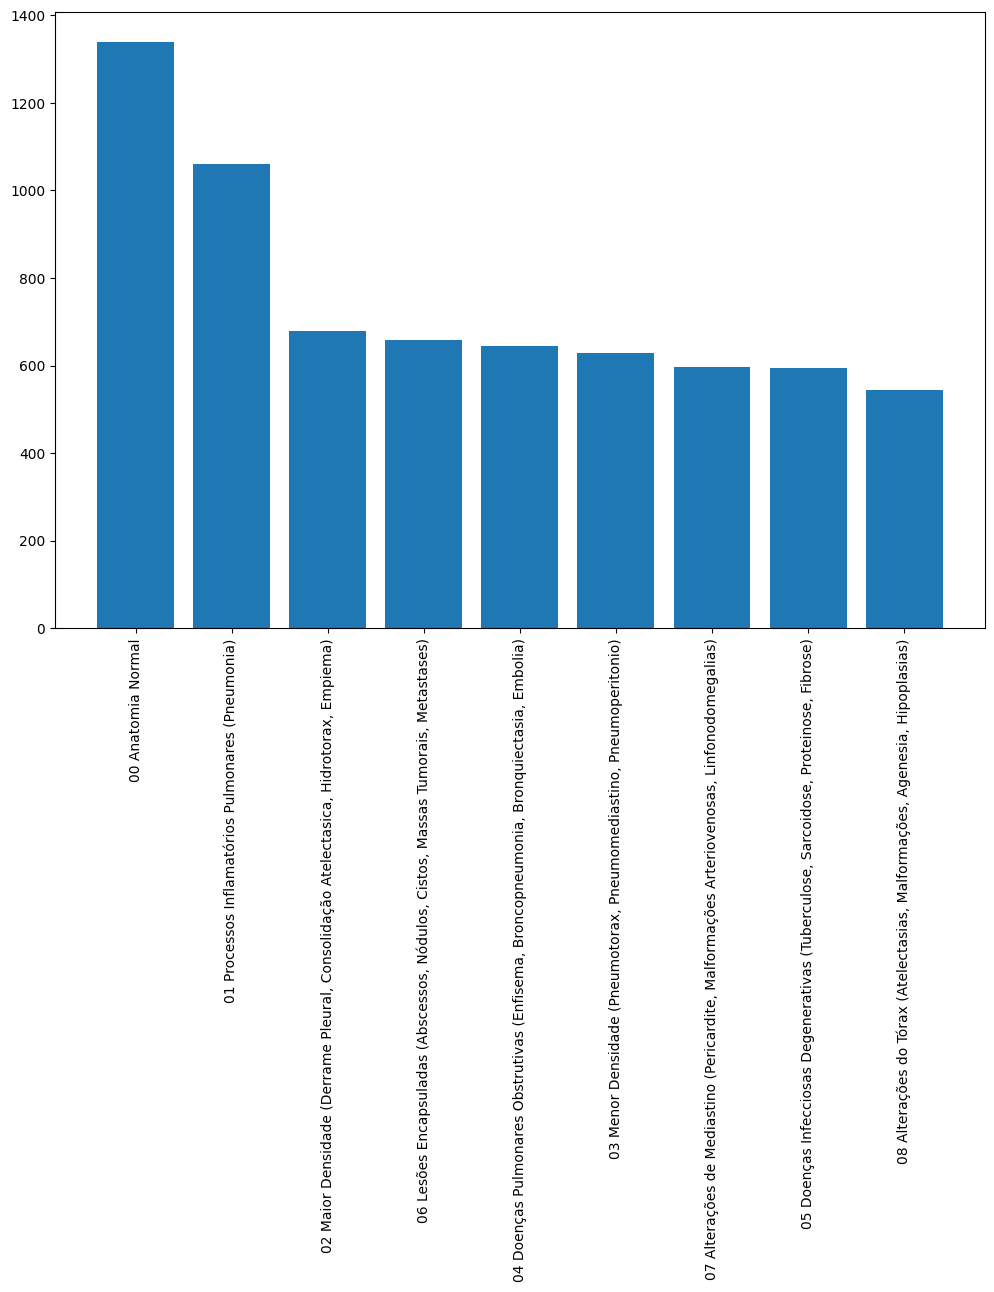

{'04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)': 644,
 '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)': 678,
 '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)': 629,
 '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)': 544,
 '06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)': 658,
 '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)': 594,
 '00 Anatomia Normal': 1340,
 '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)': 596,
 '01 Processos Inflamatórios Pulmonares (Pneumonia)': 1060}

In [2]:
def explore_dataset_structure(base_dir):
    class_counts = {}
    total_images = 0
    for root, dirs, files in os.walk(base_dir):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm'))]
        if image_files:
            rel_path = os.path.relpath(root, base_dir)
            class_counts[rel_path] = len(image_files)
            total_images += len(image_files)
    plt.figure(figsize=(12, 8))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    sorted_indices = np.argsort(counts)[::-1]
    classes = [classes[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    plt.bar(range(len(classes)), counts)
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.show()
    return class_counts

explore_dataset_structure(BASE_DIR)

100%|██████████| 500/500 [00:01<00:00, 274.27it/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Con

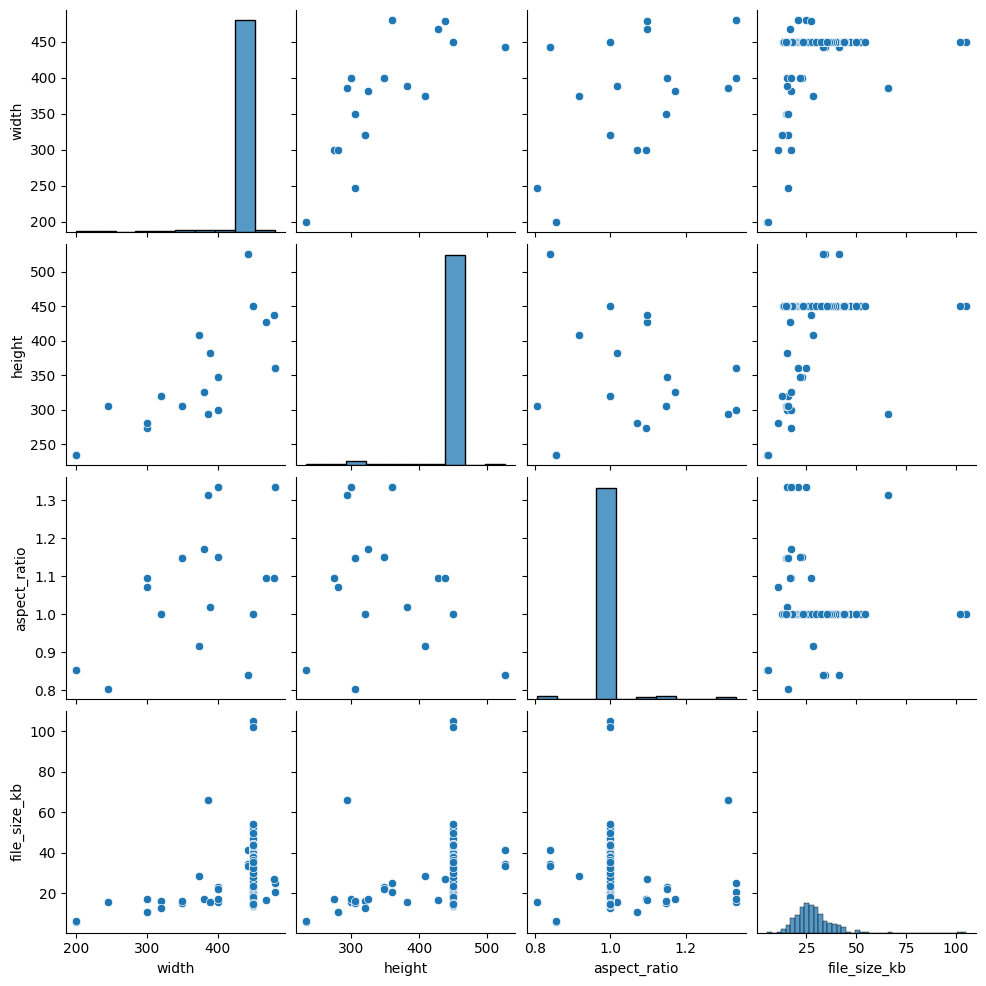

,width,height,aspect_ratio,file_size_kb
0,450,450,1.0,28.670898
1,450,450,1.0,31.416016
2,450,450,1.0,28.821289
3,450,450,1.0,22.080078
4,450,450,1.0,25.475586
...,...,...,...,...
495,450,450,1.0,23.262695
496,450,450,1.0,32.137695
497,450,450,1.0,15.054688
498,450,450,1.0,35.280273


In [3]:
def analyze_image_dimensions(base_dir, sample_size=500):
    dimensions, aspect_ratios, file_sizes = [], [], []
    all_images = [os.path.join(root, file) for root, _, files in os.walk(base_dir) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_images = np.random.choice(all_images, sample_size, replace=False) if len(all_images) > sample_size else all_images
    for img_path in tqdm(sampled_images):
        try:
            file_sizes.append(os.path.getsize(img_path) / 1024)
            img = Image.open(img_path)
            width, height = img.size
            dimensions.append((width, height))
            aspect_ratios.append(width / height)
        except:
            pass
    df = pd.DataFrame(dimensions, columns=['width', 'height'])
    df['aspect_ratio'] = aspect_ratios
    df['file_size_kb'] = file_sizes
    sns.pairplot(df)
    plt.show()
    return df

analyze_image_dimensions(BASE_DIR)

100%|██████████| 100/100 [00:00<00:00, 118.95it/s]


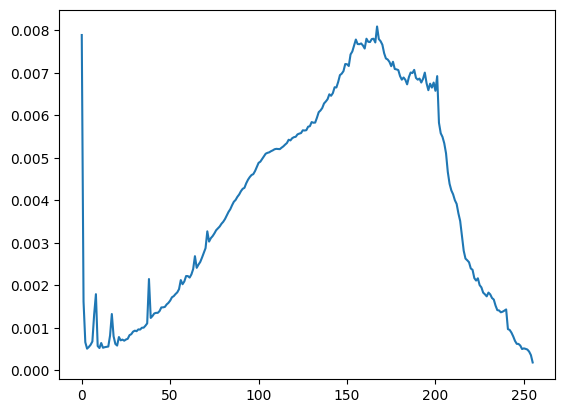

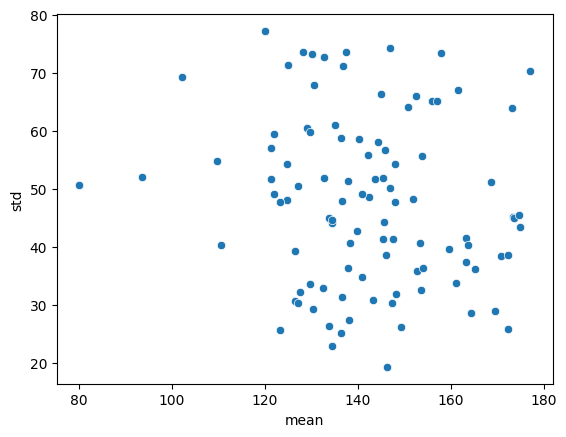

,mean,std
0,147.939862,54.223093
1,130.628212,67.895317
2,148.050879,47.761189
3,128.196983,73.491061
4,161.512632,66.979898
...,...,...
95,134.492474,22.977967
96,143.214094,30.857063
97,150.809941,64.038721
98,146.058612,38.642616


In [4]:
def analyze_pixel_intensities(base_dir, sample_size=100):
    images = [os.path.join(root, file) for root, _, files in os.walk(base_dir) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_images = np.random.choice(images, sample_size, replace=False) if len(images) > sample_size else images
    histograms, mean_intensities, std_intensities = [], [], []
    for img_path in tqdm(sampled_images):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        histograms.append(hist.flatten() / hist.sum())
        mean_intensities.append(img.mean())
        std_intensities.append(img.std())
    plt.plot(np.mean(histograms, axis=0))
    plt.show()
    df = pd.DataFrame({'mean': mean_intensities, 'std': std_intensities})
    sns.scatterplot(x='mean', y='std', data=df)
    plt.show()
    return df

analyze_pixel_intensities(BASE_DIR)

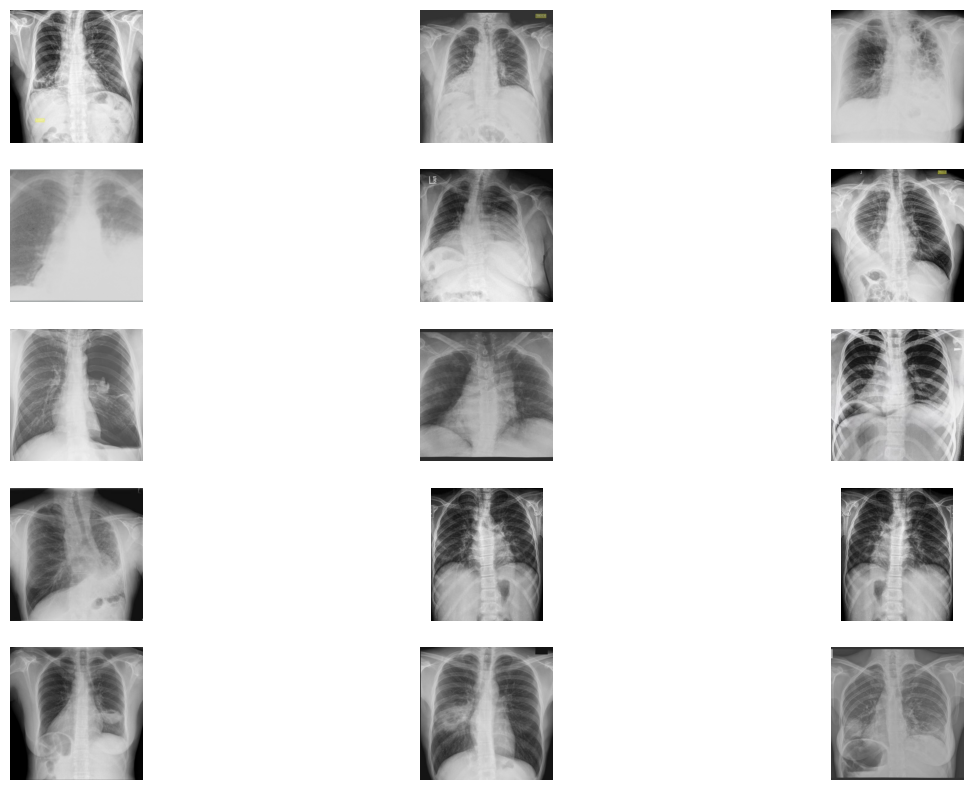

In [5]:
def visualize_sample_images(base_dir, samples_per_class=3):
    class_images = {root: [os.path.join(root, file) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))] for root, _, files in os.walk(base_dir) if any(file.lower().endswith(('.png', '.jpg', '.jpeg')) for file in files)}
    selected_classes = list(class_images.keys())[:5]
    plt.figure(figsize=(15, 10))
    for idx, cls in enumerate(selected_classes):
        for j in range(min(samples_per_class, len(class_images[cls]))):
            img = cv2.imread(class_images[cls][j])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(selected_classes), samples_per_class, idx * samples_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
    plt.show()

visualize_sample_images(BASE_DIR)

100%|██████████| 100/100 [00:01<00:00, 76.18it/s]


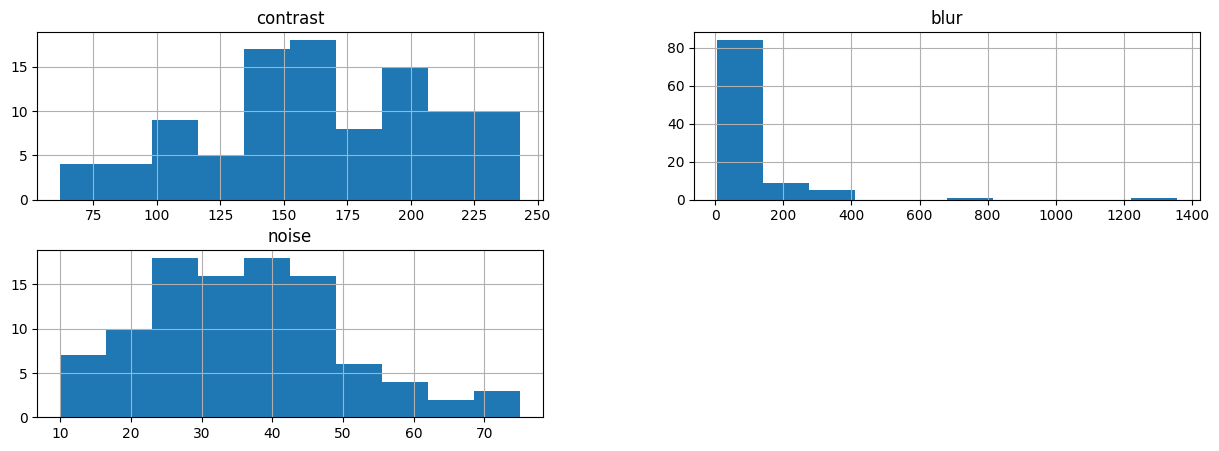

,contrast,blur,noise
0,220.0,260.739431,46.0
1,141.0,37.309612,24.0
2,157.0,62.887720,29.0
3,204.0,34.547528,24.0
4,144.0,86.920404,28.0
...,...,...,...
95,196.0,54.140086,40.0
96,197.0,33.938704,48.0
97,195.0,101.750263,58.0
98,95.0,33.089878,19.0


In [6]:
def analyze_image_quality(base_dir, sample_size=100):
    images = [os.path.join(root, file) for root, _, files in os.walk(base_dir) for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_images = np.random.choice(images, sample_size, replace=False) if len(images) > sample_size else images
    contrast, blur, noise = [], [], []
    for img_path in tqdm(sampled_images):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        p2, p98 = np.percentile(img, (2, 98))
        contrast.append(p98 - p2)
        blur.append(cv2.Laplacian(img, cv2.CV_64F).var())
        noise.append(np.median(np.abs(img - np.median(img))))
    df = pd.DataFrame({'contrast': contrast, 'blur': blur, 'noise': noise})
    df.hist(figsize=(15, 5))
    plt.show()
    return df

analyze_image_quality(BASE_DIR)